In [3]:
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

pd.set_option("mode.chained_assignment",  None) # <==== 판다스 경고를 끈다

#필요행만 선택 and 전처리
def preProcessing(df, ageNaFill="zero", dropna=True, cate="train"):
    df = df.astype({"Pclass":"str"})
    df = df.replace({"Pclass" : {"1":"1st", "2":"2nd", "3":"3nd"}})
    if ageNaFill:
        #age가 없는 사람은 0으로 채워준다
        df["Age"] = df["Age"].fillna(0.00)
    elif ageNaFill=="mean":
        age_mean = df["Age"].mean()
        df["Age"] = df["Age"].fillna(age_mean)

    df["MissCate"] = "none"
    miss_cate = ["Mrs", "Miss"]
    for i in range(len(df["PassengerId"])):
        for m_cate in miss_cate:
            if m_cate in df["Name"].loc[i]:
                df["MissCate"].loc[i] = m_cate
                
    if cate == "test":
        df_selected = df[{"PassengerId", "Age", "Parch", "SibSp", "Fare", "Pclass", "Sex", "Embarked", "MissCate"}]
    elif cate == "train":
        df_selected = df[{"Survived", "Age", "Parch", "SibSp", "Fare", "Pclass", "Sex", "Embarked", "MissCate"}]
    elif cate == "compare":
        df_selected = df[{"PassengerId", "Survived", "Age", "Parch", "SibSp", "Fare", "Pclass", "Sex", "Embarked", "MissCate"}]
    
    if dropna:
        df_selected = df_selected.dropna()

    #Age와 Fare 정규화
    df_selected["Age"] = (df_selected["Age"] - df_selected["Age"].mean())/df_selected["Age"].std() #normalize
    df_selected["Fare"] = (df_selected["Fare"] - df_selected["Fare"].mean())/df_selected["Age"].std() #normalize

    #Label Encoding 방식 변환
    # df_selected["Sex_number"] = df_selected["Sex"].replace("female", 1).replace("male", 2)
    # df_selected["Embarked_number"] = df_selected["Embarked"].replace("C", 1).replace("Q", 2).replace("S", 3)

    #One hot encoding 방식 변환
    df_one_hot_encoded = pd.get_dummies(df[{"Pclass", "Sex", "Embarked", "MissCate"}])
    df_selected_for_merge = df_selected.drop({"Pclass", "Sex", "Embarked", "MissCate"}, axis = 1)
    df_selected = pd.merge(df_selected_for_merge, df_one_hot_encoded, how="left", left_index=True, right_index=True)
    
    return df_selected

df = pd.read_csv("train.csv")
display(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
#데이터셋 분리
org_data = preProcessing(df, ageNaFill="mean")
x = org_data.drop("Survived", axis=1)
y = org_data["Survived"]
display(x)
display(y)

,Fare,Age,Parch,SibSp,Sex_female,Sex_male,MissCate_Miss,MissCate_Mrs,MissCate_none,Pclass_1st,Pclass_2nd,Pclass_3nd,Embarked_C,Embarked_Q,Embarked_S
0,-24.846681,-0.099094,0,1,0,1,0,0,1,0,0,1,0,0,1
1,39.186619,0.811932,0,1,1,0,0,1,0,1,0,0,1,0,0
2,-24.171681,0.128663,0,0,1,0,1,0,0,0,0,1,0,0,1
3,21.003319,0.641115,0,1,1,0,0,1,0,1,0,0,0,0,1
4,-24.046681,0.641115,0,0,0,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-19.096681,0.185602,0,0,0,1,0,0,1,0,1,0,0,0,1
887,-2.096681,-0.269911,0,0,1,0,1,0,0,1,0,0,0,0,1
888,-8.646681,-1.351755,2,1,1,0,1,0,0,0,0,1,0,0,1
889,-2.096681,0.128663,0,0,0,1,0,0,1,1,0,0,1,0,0


0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, shuffle=True, random_state=34)
x_train, x_test, y_train, y_test = x_train.to_numpy(), x_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

display(x_train.shape)
display(y_train.shape)


(844, 15)

(844,)

In [11]:
# 네트워크 구조 정의. VGG를 차용하여 조금 수정함
class_counts = 2
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x_train.shape[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dense(units=class_counts, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
            loss="sparse_categorical_crossentropy", 
            metrics=["accuracy"])

#계층, 차원, 파라미터 수 요약 확인
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 15)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15)                60        
_________________________________________________________________
dense_12 (Dense)             (None, 256)               4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                

클래스 갯수 : 2
에포크 횟수 : 50
Epoch 1/50
24/24 [==============================] - 1s 16ms/step - loss: 0.5645 - accuracy: 0.6713 - val_loss: 0.5780 - val_accuracy: 0.7529
Epoch 2/50
24/24 [==============================] - 0s 9ms/step - loss: 0.4730 - accuracy: 0.7698 - val_loss: 0.5519 - val_accuracy: 0.7765
Epoch 3/50
24/24 [==============================] - 0s 12ms/step - loss: 0.4415 - accuracy: 0.8327 - val_loss: 0.5036 - val_accuracy: 0.7882
Epoch 4/50
24/24 [==============================] - 0s 14ms/step - loss: 0.3992 - accuracy: 0.8226 - val_loss: 0.4870 - val_accuracy: 0.7882
Epoch 5/50
24/24 [==============================] - 0s 12ms/step - loss: 0.4106 - accuracy: 0.8194 - val_loss: 0.4642 - val_accuracy: 0.8118
Epoch 6/50
24/24 [==============================] - 0s 10ms/step - loss: 0.4118 - accuracy: 0.8150 - val_loss: 0.4693 - val_accuracy: 0.7882
Epoch 7/50
24/24 [==============================] - 0s 9ms/step - loss: 0.4281 - accuracy: 0.7812 - val_loss: 0.4629 - val_accuracy:

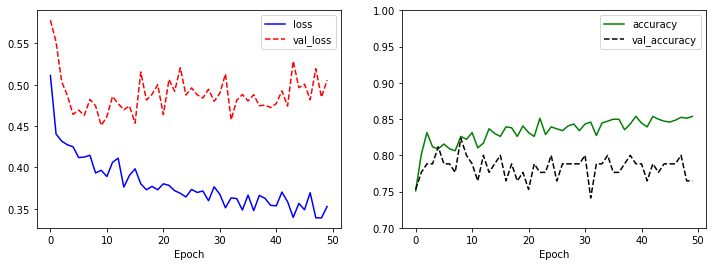

2/2 [==============================] - 0s 3ms/step - loss: 0.3363 - accuracy: 0.8667
최종 결과 :  [0.33633482456207275, 0.8666666746139526]


In [12]:
epoch_counts = 50
print("클래스 갯수 : " + str(class_counts))
print("에포크 횟수 : " + str(epoch_counts))
history = model.fit(
    x_train,
    y_train,
    epochs=epoch_counts,
    validation_split=0.1
)

 #train loss, validation loss 그래프 출력
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], "b-", label="loss")
plt.plot(history.history["val_loss"], "r--", label="val_loss")
plt.xlabel("Epoch")
plt.legend()

#train accutacy, validation accuracy 그래프 출력
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], "g-", label="accuracy")
plt.plot(history.history["val_accuracy"], "k--", label="val_accuracy")
plt.xlabel("Epoch")
plt.ylim(0.7, 1)
plt.legend()
plt.show()

print("최종 결과 : ", model.evaluate(x_test, y_test))

try:
    json_string = model.to_json()
    open("saved_dnn_model_json.json", "w").write(json_string)
    model.save_weights("saved_dnn_model_weights.h5", overwrite=True)
    with open("dnn_class_names.json", "w") as outfile:
        json.dump({0:"die", 1:"survived"}, outfile)
except Exception as e:
    print("=================================")
    print("=================================")
    print("모델 저장 중 오류가 발생하였습니다!", e)
    print("=================================")
    print("=================================")


In [15]:
#test 데이터를 가지고 예측
# test_df = pd.read_csv("test.csv")
# test_df = preProcessing(test_df, dropna=False, cate="test")

#train 데이터로 재예측
test_df = pd.read_csv("train.csv")
test_df = preProcessing(test_df, ageNaFill="mean", dropna=False, cate="compare")

#모델 로드
model_dir = ""
model_trained = tf.keras.models.model_from_json(open(model_dir + "saved_dnn_model_json.json").read())
model_trained.load_weights(model_dir + "saved_dnn_model_weights.h5")
model_trained.compile(optimizer=tf.keras.optimizers.Adam(), 
            loss="sparse_categorical_crossentropy", 
            metrics=["accuracy"])
model_trained_face_class_names_file = model_dir + "dnn_class_names.json"
with open(model_trained_face_class_names_file, "r") as json_file:
    model_trained_face_class_names = json.load(json_file)

test_df["Survived_predicted"] = 0
test_df["Probability_die"] = 0.00
test_df["Probability_survive"] = 0.00
for i in range(len(test_df["PassengerId"])):
    if i > 0:
        print("{}% 예측 진행중...".format(math.ceil((i / len(test_df["PassengerId"]))*100)), end="\r")
    this_df = test_df.loc[i]
    this_df_for_predict = this_df.drop({"PassengerId", "Survived", "Survived_predicted", "Probability_die", "Probability_survive"}, axis=0)
    this_df_for_predict = this_df_for_predict.to_numpy().astype("float64").reshape(-1, 15, 1)
    this_predict = model_trained.predict(this_df_for_predict)
    this_class_no = np.argmax(this_predict.flatten(), axis=-1)
    test_df["Survived_predicted"].loc[i] = int(this_class_no)
    test_df["Probability_die"].loc[i] = this_predict[0][0]
    test_df["Probability_survive"].loc[i] = this_predict[0][1]
    
test_df["Prediction_success"] = 0
test_df = test_df[["PassengerId", "Prediction_success", "Survived", "Survived_predicted", "Probability_die", "Probability_survive", "Age", "SibSp", "Fare", "Parch", "Embarked_C", "Embarked_Q", "Embarked_S", "Pclass_1st", "Pclass_2nd", "Pclass_3nd", "MissCate_Miss", "MissCate_Mrs", "MissCate_none", "Sex_female", "Sex_male"]]
for i in range(len(test_df["PassengerId"])):
    if test_df["Survived"].loc[i] == test_df["Survived_predicted"].loc[i]:
        test_df["Prediction_success"].loc[i] = 1

#예측 성공률
success_ratio = int((test_df["Prediction_success"].sum()/len(test_df["PassengerId"]))*100)
print("예측 성공률(정확도) : {}%".format(success_ratio))

display(test_df)
test_df.to_excel(
    "test_results.xlsx",
    sheet_name = "Sheet1",
    # na_rep = 'NaN',
#     float_format = "%.2f",
    header = True, 
    index = True, 
    index_label = "id", 
    startrow = 0, 
    startcol = 0, 
    freeze_panes = (1, 0)
)

예측 성공률(정확도) : 86%


,PassengerId,Prediction_success,Survived,Survived_predicted,Probability_die,Probability_survive,Age,SibSp,Fare,Parch,...,Embarked_Q,Embarked_S,Pclass_1st,Pclass_2nd,Pclass_3nd,MissCate_Miss,MissCate_Mrs,MissCate_none,Sex_female,Sex_male
0,1,1,0,0,0.777351,0.222649,-0.102255,1,-24.954208,0,...,0,1,0,0,1,0,0,1,0,1
1,2,1,1,1,0.000013,0.999987,0.807038,1,39.079092,0,...,0,0,1,0,0,0,1,0,1,0
2,3,1,1,1,0.470876,0.529124,0.125068,0,-24.279208,0,...,0,1,0,0,1,1,0,0,1,0
3,4,1,1,1,0.000014,0.999986,0.636546,1,20.895792,0,...,0,1,1,0,0,0,1,0,1,0
4,5,1,0,0,0.853885,0.146115,0.636546,0,-24.154208,0,...,0,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1,0,0,0.902508,0.097492,0.181899,0,-19.204208,0,...,0,1,0,1,0,0,0,1,0,1
887,888,1,1,1,0.000230,0.999770,-0.272748,0,-2.204208,0,...,0,1,1,0,0,1,0,0,1,0
888,889,0,0,1,0.454499,0.545501,-1.352534,1,-8.754208,2,...,0,1,0,0,1,1,0,0,1,0
889,890,1,1,1,0.362524,0.637476,0.125068,0,-2.204208,0,...,0,0,1,0,0,0,0,1,0,1


In [21]:
#test 데이터를 가지고 예측
test_df = pd.read_csv("test.csv")
test_df = preProcessing(test_df, ageNaFill="mean", dropna=False, cate="test")

#모델 로드
model_dir = ""
model_trained = tf.keras.models.model_from_json(open(model_dir + "saved_dnn_model_json.json").read())
model_trained.load_weights(model_dir + "saved_dnn_model_weights.h5")
model_trained.compile(optimizer=tf.keras.optimizers.Adam(), 
            loss="sparse_categorical_crossentropy", 
            metrics=["accuracy"])
model_trained_face_class_names_file = model_dir + "dnn_class_names.json"
with open(model_trained_face_class_names_file, "r") as json_file:
    model_trained_face_class_names = json.load(json_file)

test_df["Survived_predicted"] = 0
test_df["Probability_die"] = 0.00
test_df["Probability_survive"] = 0.00
for i in range(len(test_df["PassengerId"])):
    if i > 0:
        print("test.csv {}% 예측 진행중...".format(math.ceil((i / len(test_df["PassengerId"]))*100)), end="\r")
    this_df = test_df.loc[i]
    this_df_for_predict = this_df.drop({"PassengerId", "Survived_predicted", "Probability_die", "Probability_survive"}, axis=0)
    this_df_for_predict = this_df_for_predict.to_numpy().astype("float64").reshape(-1, 15, 1)
    this_predict = model_trained.predict(this_df_for_predict)
    this_class_no = np.argmax(this_predict.flatten(), axis=-1)
    test_df["Survived_predicted"].loc[i] = int(this_class_no)
    test_df["Probability_die"].loc[i] = this_predict[0][0]
    test_df["Probability_survive"].loc[i] = this_predict[0][1]
    
test_df = test_df[["PassengerId", "Survived_predicted", "Probability_die", "Probability_survive", "Age", "SibSp", "Fare", "Parch", "Embarked_C", "Embarked_Q", "Embarked_S", "Pclass_1st", "Pclass_2nd", "Pclass_3nd", "MissCate_Miss", "MissCate_Mrs", "MissCate_none", "Sex_female", "Sex_male"]]
gender_submission_df = test_df[["PassengerId", "Survived_predicted"]]
gender_submission_df.rename(columns = {"Survived_predicted" : "Survived"}, inplace = True)

display(test_df)
display(gender_submission_df)

test_df.to_excel(
    "test_results_for_submission.xlsx",
    sheet_name = "Sheet1",
    # na_rep = 'NaN',
#     float_format = "%.2f",
    header = True, 
    index = True, 
    index_label = "id", 
    startrow = 0, 
    startcol = 0, 
    freeze_panes = (1, 0)
)

gender_submission_df.to_csv("gender_submission.csv", mode="w", index=False)
print("예측결과 gender_submission.csv로 저장완료")

,PassengerId,Survived_predicted,Probability_die,Probability_survive,Age,SibSp,Fare,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1st,Pclass_2nd,Pclass_3nd,MissCate_Miss,MissCate_Mrs,MissCate_none,Sex_female,Sex_male
0,892,0,0.836792,0.163208,0.594089,0,-27.797988,0,0,1,0,0,0,1,0,0,1,0,1
1,893,0,0.595151,0.404849,1.304333,1,-28.627188,0,0,0,1,0,0,1,0,1,0,1,0
2,894,0,0.980991,0.019009,2.156624,0,-25.939688,0,0,1,0,0,1,0,0,0,1,0,1
3,895,0,0.862941,0.137059,0.167944,0,-26.964688,0,0,0,1,0,0,1,0,0,1,0,1
4,896,0,0.536004,0.463996,-0.116154,1,-23.339688,1,0,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,0.965322,0.034677,-1.366181,0,-27.577188,0,0,0,1,0,0,1,0,0,1,0,1
414,1306,1,0.000117,0.999884,0.849777,0,73.272812,0,1,0,0,1,0,0,0,0,1,1,0
415,1307,0,0.867157,0.132843,0.821367,0,-28.377188,0,0,0,1,0,0,1,0,0,1,0,1
416,1308,0,0.965322,0.034677,-1.366181,0,-27.577188,0,0,0,1,0,0,1,0,0,1,0,1


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


예측결과 gender_submission.csv로 저장완료
